## Final Project Submission

Please fill out:
* Student name: Collin Loo
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: James M Irving, Ph.D.
* Blog post URL: 

## Project Roadmap

#### Objectives:
The purpose of this project is to develop a time series model to evaluate if a selected property meet the investment strategy criteria of a real estate investment company.

#### Business Case:
Using historical data, we select five zip codes based on the following requirements.
1. Property must have a price to rent ratio between 12-20 because this is a good indicator to tell whether people are incline to rent or own a home.

Calculation:  *median home price / median annual rental*   
where Median Annual Rental = Zillow Rental Index * 12  
    
2. ROI on the sale of the property should be greater than 10%. 

Calculation: (*Sale price after 5 years - (sale price - (purchase price*0.035)+20000) / (purchase price*0.035)+20000*   
where 0.035 = closing cost  
20000 = general repair    
    
3. Cash on Cash ratio should be greater than 8%.  

Calculation: *((Rental * 12) - (Mort. Payment + Insurance + Vacancy Allowance)) / (Down Payment + Closing Cost)*  
where Rental = Zillow Rental Index  
Mort. payment = Loan x ((Interest rate/12) x (1+Interest rate/12))sq(Mort. Term) / (1+Interest rate/12))sq(Mort.Term)-1)  
Loan = Property purchase price * 0.80   
Interest rate = 2.5%  
Mort.Term = 360 (30yrs mortgage)  
Insurance = (Property purchase price / 100,000) * 40  
Vacancy Allowance = Rental Index * 0.10  
Down Payment = Property purchase price * 0.20  
Closing Cost = Property purchase price * 0.035  
    
5. Standard deviation of Rental Index should be in the range of 35% to 65 % quantile.  This is to reduce rental market volatility.  
    
    
6. We will develop the model based on the filtered data set.

#### Project Approach
We will follows the OSEMN framework during the project execution.  Firstly, we will create a base model, using the EDA process to derive the order parameter for the ARIMA model.  Secondly, utilize the grid search process to find the optimum order parameter for the ARIMA model.  Lastly, We will choose the best model based on the lowest Root Mean Square Error that the model produces.

***
## Obtain Data

#### Import Main Dataset

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from my_func import *

%matplotlib inline

In [2]:
df = pd.read_csv('data\zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

#### Import Zillow Observed Rent Index (ZORI) with Computed Investment Metrics

- The Zillow Observed Rent Index can be downloaded from https://www.zillow.com/research/data/
- ROI, price to rent ratio, cash on cash and rental standard deviation are calculated using the rental index and the median home value from the main dataset.  Detail calculation can be found in the Excel spreadsheet in the data directory.  (Metro_ZORI.xlsx)

In [3]:
# import Zillow Observed Rent Index (ZORI)
df_zori = pd.read_csv('data/Invest_Metrics.csv')

# preview data
df_zori.head()

RegionName        PTR       ROI       COC    RStdDev
0       60657  50.136213  0.116030 -0.099500  52.309031
1       75070  18.107135  0.220608  0.024231  73.617040
2       77494  18.933655  0.050145  0.016517  33.665787
3       60614  63.582409  0.075161 -0.116054  52.309031
4       79936   9.498124 -0.109482  0.131037   6.692658

In [4]:
df_zori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8670 entries, 0 to 8669
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  8670 non-null   int64  
 1   PTR         8670 non-null   float64
 2   ROI         8670 non-null   float64
 3   COC         8670 non-null   float64
 4   RStdDev     8670 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 338.8 KB


In [5]:
# combine the two dataframes
df_comb = pd.merge(df, df_zori, on='RegionName')

# preview data
df_comb.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-11  2017-12  2018-01  \
0         1  334200.0  335400.0  336500.0  ...  1013300  1018700  1024400   
1         2  235700.0  236900.0  236700.0  ...   315000   316600   318100   
2         3  210400.0  212200.0  212200.0  ...   320800   321200   321200   
3         4  498100.0  500900.0  503100.0  ...  1296600  1299000  1302700   
4         5   77300.0   77300.0   77300.0  ...   120300   120300   120300   

   2018-02  2018-03  2018-04        PTR       ROI       COC    RStdDev  
0  1030700  1033800  1030600  50.136213  0.116030 -0.099500  52.309031  
1   319600   321100   321800  18.107135  0.220608  0.024231  73.617040  
2   323000   326900   329900  18.933655  0.050145  0.016517  33.665787  
3  1306400  1308500  1307000  63.582409  0.075161 -0.116054  52.309031  
4   120500   121000   121500   9.498124 -0.109482  0.131037   6.692658  

[5 rows x 276 columns]

***
## Preprocess Data

In [6]:
# examine columns 
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8670 entries, 0 to 8669
Columns: 276 entries, RegionID to RStdDev
dtypes: float64(223), int64(49), object(4)
memory usage: 18.3+ MB


### Subset Data Based on Investment Strategies

**Subset the data based on the following assumptions:**
1. Properties must have a price to rent ration between 12 - 20 as this is a good indicator
   for people to choose renting over owning.
2. Return on investment should be greater than 10%.
3. Cash on cash return rate should be greater than 8%.
4. Rental index standard deviation should be within the 30% to 60% quantile to minimize
   risk and volatility.

In [7]:
# filter data
roi = df_comb[df_comb['ROI'] > 0.10]
ptr = roi[(roi['PTR'] > 11) & (roi['PTR'] < 25)]
coc = ptr[ptr['COC'] > 0.08]
q_low, q_high = coc['RStdDev'].quantile([.3, .6])
df_filtered = coc[(coc['RStdDev'] >= q_low) & (coc['RStdDev'] <= q_high)]

# preview filtered data
df_filtered.head()

RegionID  RegionName            City State                  Metro  \
23      69816       28269       Charlotte    NC              Charlotte   
32      90654       75052   Grand Prairie    TX      Dallas-Fort Worth   
78      72363       33025         Miramar    FL  Miami-Fort Lauderdale   
121     72362       33024  Pembroke Pines    FL  Miami-Fort Lauderdale   
123     72347       33009      Hallandale    FL  Miami-Fort Lauderdale   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-11  \
23   Mecklenburg        25  126100.0  126600.0  127100.0  ...   191700   
32        Dallas        35  100800.0  100900.0  101000.0  ...   193000   
78       Broward        83  111600.0  111700.0  111800.0  ...   289700   
121      Broward       131   87100.0   87200.0   87200.0  ...   261900   
123      Broward       133   79500.0   79500.0   79600.0  ...   239000   

     2017-12  2018-01  2018-02  2018-03  2018-04        PTR       ROI  \
23    193500   195100   196600   198500   199700  12.103030  0.161465   
32    194300   195200   196700   199100   201100  11.315553  0.241343   
78    291000   292500   294200   296400   298200  13.468835  0.402545   
121   263700   265600   267800   269800   270900  12.235772  0.411573   
123   241000   242600   245100   248100   250000  11.291780  0.555113   

          COC    RStdDev  
23   0.097060  70.566747  
32   0.113830  73.617040  
78   0.083379  73.506797  
121  0.104384  73.506797  
123  0.123637  73.506797  

[5 rows x 276 columns]

**To diversify our investment profile, we will pick the top 5 zip codes based on:**
1. Property showing highest ROI.
2. One zip code per State.

In [8]:
# get list of States
states = df_filtered.State.unique()
df_top_states = pd.DataFrame()

# select top zip code from each state
for state in states:
    tmp = df_filtered[(df_filtered['State'] == state)]
#     df_top_states = df_top_states.append(tmp[tmp['ROI'] == tmp['ROI'].max()])
    df_top_states = df_top_states.append(tmp.nlargest(3, 'ROI'))
    
# preview dataframe
display(df_top_states.head())

RegionID  RegionName            City State              Metro  \
422      69789       28227       Mint Hill    NC          Charlotte   
795      69813       28262       Charlotte    NC          Charlotte   
1503     69820       28273       Charlotte    NC          Charlotte   
2520     90786       75234  Farmers Branch    TX  Dallas-Fort Worth   
5684     90785       75233          Dallas    TX  Dallas-Fort Worth   

       CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-11  \
422   Mecklenburg       473  101700.0  102100.0  102600.0  ...   178900   
795   Mecklenburg       919  125200.0  125700.0  126300.0  ...   184000   
1503  Mecklenburg      1815  115000.0  115300.0  115700.0  ...   191600   
2520       Dallas      3158   91100.0   91000.0   90900.0  ...   221300   
5684       Dallas      7886   81400.0   81500.0   81600.0  ...   185400   

      2017-12  2018-01  2018-02  2018-03  2018-04        PTR       ROI  \
422    181300   183400   185800   189200   192100  11.642424  0.220085   
795    185900   187200   188800   190900   192300  11.654545  0.182490   
1503   193300   194700   196100   197900   199000  12.060606  0.174360   
2520   224100   228700   232100   233600   234000  13.166779  0.519160   
5684   187300   188900   191700   198000   204100  11.484357  0.517799   

           COC    RStdDev  
422   0.105303  70.566747  
795   0.104810  70.566747  
1503  0.097857  70.566747  
2520  0.084052  73.617040  
5684  0.112431  73.617040  

[5 rows x 276 columns]

### Format Data for Time Series

In [9]:
# define non-date columns
id_vars = ['RegionID', 'RegionName', 'City','State', 'Metro', 'CountyName',
            'SizeRank', 'PTR', 'ROI', 'COC', 'RStdDev']

df_ts = pd.melt(df_top_states, id_vars=id_vars, var_name='time')
df_ts['time'] = pd.to_datetime(df_ts['time'], infer_datetime_format=True)
# preview dataframe
df_ts.head()

RegionID  RegionName            City State              Metro   CountyName  \
0     69789       28227       Mint Hill    NC          Charlotte  Mecklenburg   
1     69813       28262       Charlotte    NC          Charlotte  Mecklenburg   
2     69820       28273       Charlotte    NC          Charlotte  Mecklenburg   
3     90786       75234  Farmers Branch    TX  Dallas-Fort Worth       Dallas   
4     90785       75233          Dallas    TX  Dallas-Fort Worth       Dallas   

   SizeRank        PTR       ROI       COC    RStdDev       time     value  
0       473  11.642424  0.220085  0.105303  70.566747 1996-04-01  101700.0  
1       919  11.654545  0.182490  0.104810  70.566747 1996-04-01  125200.0  
2      1815  12.060606  0.174360  0.097857  70.566747 1996-04-01  115000.0  
3      3158  13.166779  0.519160  0.084052  73.617040 1996-04-01   91100.0  
4      7886  11.484357  0.517799  0.112431  73.617040 1996-04-01   81400.0

### Top Five Zip Codes

We ran a preliminary grid search on the ARIMA models for all the zip codes in the df_ts.  We selected the following top five zip codes (with ROI greater than 10%) for analysis:  


In [10]:
# define zip codes for analysis
zip_codes = [28227, 28262, 28273, 75234, 75233]
zip_codes

[28227, 28262, 28273, 75234, 75233]

***
## Explore Data

### General Plot of Home Values

In [11]:
tmp = df_ts[df_ts['RegionName'].isin(zip_codes)]
# plot_ts(tmp)

In [12]:
# subset data after the 2008 crisis
df_ts_af_crisis = tmp[tmp.time > '2008-12-01']
# plot_ts(df_ts_af_crisis)

### Stationarity Check

ARMA model requires time series to be stationary.  Since our time series exhibit a linear upward trend, we will need to remove such trend using one of the detrending methods, differencing, and deploy Augmented Dickey=Fuller (ADF) test to validate our results.  In addition, we will subset the top 5 zip codes data set using cutoff date of 2011-12-01.

In [13]:
# check stationarity
df_ts_af_crisis = df_ts[df_ts.time > '2011-12-01']
stationarity_diff_chk(df_ts_af_crisis, zip_codes, periods=1, plot=True, diff_n=1)

Test Statistic   p-value  #Lags Used  \
28227, Differencing       -0.755917  0.831729           4   
28262, Differencing       -1.388621  0.587719          11   
28273, Differencing       -3.160418  0.022393           4   
75234, Differencing       -1.471654  0.547484           2   
75233, Differencing       -1.259494  0.647494           7   

                     # of Observations Used  p<.05  Stationary?  
28227, Differencing                      70  False        False  
28262, Differencing                      63  False        False  
28273, Differencing                      70   True         True  
75234, Differencing                      72  False        False  
75233, Differencing                      67  False        False

In [14]:
# perform 2nd order differencing
stationarity_diff_chk(df_ts_af_crisis, zipcode=[28227, 28262, 75234, 75233],
                      periods=1, plot=True, diff_n=2)


Test Statistic       p-value  #Lags Used  \
28227, Differencing       -4.935954  2.966938e-05           3   
28262, Differencing       -4.743703  6.960471e-05          12   
75234, Differencing       -8.347889  3.050269e-13           1   
75233, Differencing       -3.484909  8.383220e-03           6   

                     # of Observations Used  p<.05  Stationary?  
28227, Differencing                      70   True         True  
28262, Differencing                      61   True         True  
75234, Differencing                      72   True         True  
75233, Differencing                      67   True         True

### Define Train and Test Data Set Cutoff

In [15]:
# separate data into train and validation set
df_train = df_ts_af_crisis[(df_ts_af_crisis.time > '2011-12-01')
                           & (df_ts_af_crisis.time < '2016-06-01')]
df_val = df_ts_af_crisis[(df_ts_af_crisis.time > '2016-05-01')]

# verify no data overlap
display(df_train.tail(3))
display(df_val.head(3))

# check train data set percent allocated
print(f'\n*** Percent allocated to train set:\
      {round(len(df_train)/len(df_ts_af_crisis), 2)} ***')

RegionID  RegionName              City State       Metro  CountyName  \
5563     58986        2911  North Providence    RI  Providence  Providence   
5564     94220       83605          Caldwell    ID  Boise City      Canyon   
5565     94255       83651             Nampa    ID  Boise City      Canyon   

      SizeRank        PTR       ROI       COC    RStdDev       time     value  
5563      6335  12.805556  0.224842  0.088461  75.634847 2016-05-01  188400.0  
5564      3075  12.203687  0.237559  0.090381  76.302438 2016-05-01  133000.0  
5565      3551  12.832894  0.177489  0.080855  76.302438 2016-05-01  141600.0

RegionID  RegionName       City State      Metro   CountyName  SizeRank  \
5566     69789       28227  Mint Hill    NC  Charlotte  Mecklenburg       473   
5567     69813       28262  Charlotte    NC  Charlotte  Mecklenburg       919   
5568     69820       28273  Charlotte    NC  Charlotte  Mecklenburg      1815   

            PTR       ROI       COC    RStdDev       time     value  
5566  11.642424  0.220085  0.105303  70.566747 2016-06-01  154400.0  
5567  11.654545  0.182490  0.104810  70.566747 2016-06-01  159900.0  
5568  12.060606  0.174360  0.097857  70.566747 2016-06-01  165200.0


*** Percent allocated to train set:      0.7 ***


***
## Model B

### Generate pdq Combinations

In [16]:
# gen arima model with range = 0,2
# define p,d & q parameters
p = d = q = range(0,3)

# generate different combination of p,d,q
pdq = list(itertools.product(p,d,q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


### Grid Search Optimum pdq

In [17]:
# select ariama model based on lowest AIC scores
arima_param_b = gen_arima_params(df_train, zip_codes, pdq[:-3], enf_stationarity=False)

# display optimum pdq from grid search
arima_param_b

zc        pdq         AIC
8    28227  (0, 2, 2)  680.897177
32   28262  (0, 2, 2)  682.592522
65   28273  (1, 2, 2)  705.460398
80   75234  (0, 2, 2)  699.466137
113  75233  (1, 2, 2)  706.103843

In [18]:
# define prediction start date
pred_sd_b = '2013-01-01'

### Zip Code 89104 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [19]:
zc_1 = 28227

*** ARIMA Parameters, (0, 2, 2) ***
*** Coefficients Statistics, 28227 ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, 28227 ***


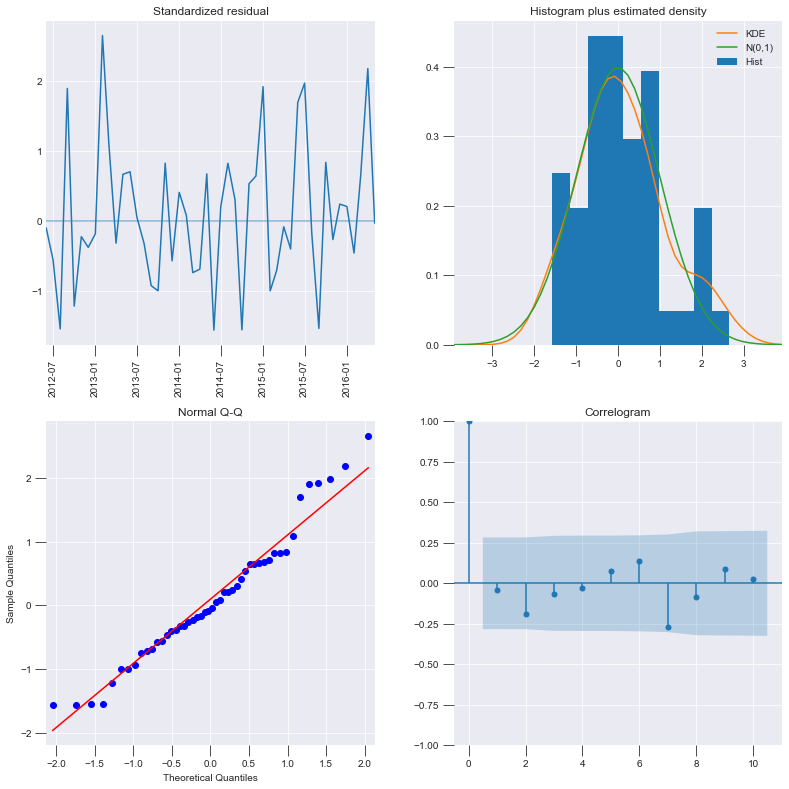

In [20]:
# define empty list to store mse and rmse
out_list_b = []

# fit model and plot diagnostic figures
fit_arima_model(df_train, arima_param_b, zc_1)

#### One-Step Ahead Forecast (dynamic=False)

In [21]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_1, pred_start_date=pred_sd_b)
out_list_b.append(output_b)

The mean square error of our forcast is : 73122.34.
The root mean square error of our forcast is 270.41.


#### One-Step Ahead Forecast (dynamic=True)

In [22]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_1,
                             pred_start_date=pred_sd_b, dynamic=True)
out_list_b.append(output_b)

The mean square error of our forcast is : 687402840.35.
The root mean square error of our forcast is 26218.37.


### Zip Code 32204 ARIMA Results

In [23]:
zc_2 = 28262

#### Coefficient P-Values and Diagnostic Plots

*** ARIMA Parameters, (0, 2, 2) ***
*** Coefficients Statistics, 28262 ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, 28262 ***


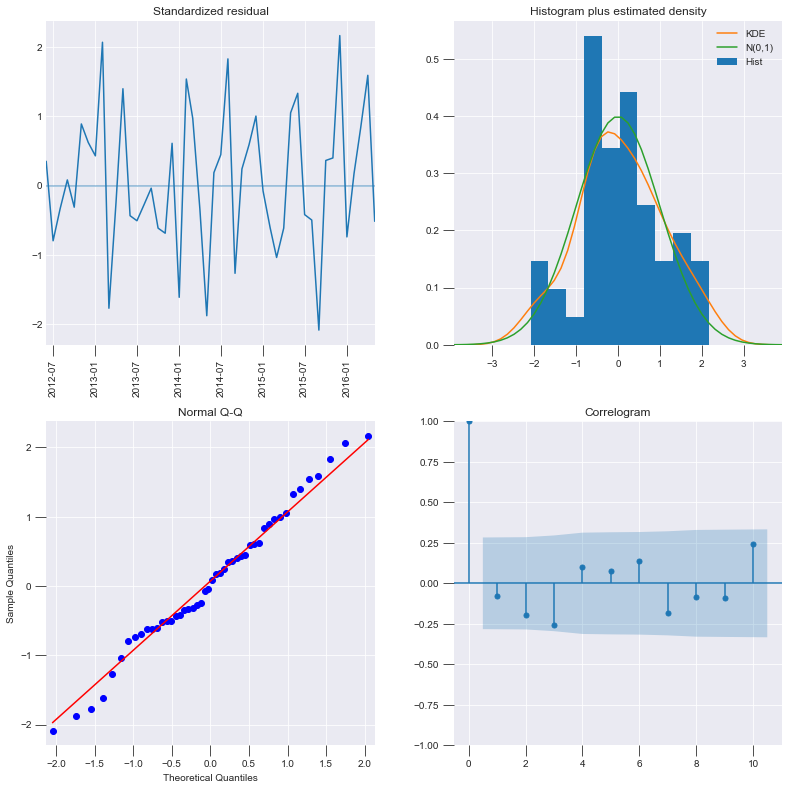

In [24]:
fit_arima_model(df_train, arima_param_b, zc_2)

#### One-Step Ahead Forecast (dynamic=False)

In [25]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_2, pred_start_date=pred_sd_b)
out_list_b.append(output_b)

The mean square error of our forcast is : 86623.5.
The root mean square error of our forcast is 294.32.


#### One-Step Ahead Forecast (dynamic-True)

In [26]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_2,
                             pred_start_date=pred_sd_b, dynamic=True)
out_list_b.append(output_b)

The mean square error of our forcast is : 28656225.91.
The root mean square error of our forcast is 5353.15.


### Zip Code 48220 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [27]:
zc_3 = 28273

*** ARIMA Parameters, (1, 2, 2) ***
*** Coefficients Statistics, 28273 ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, 28273 ***


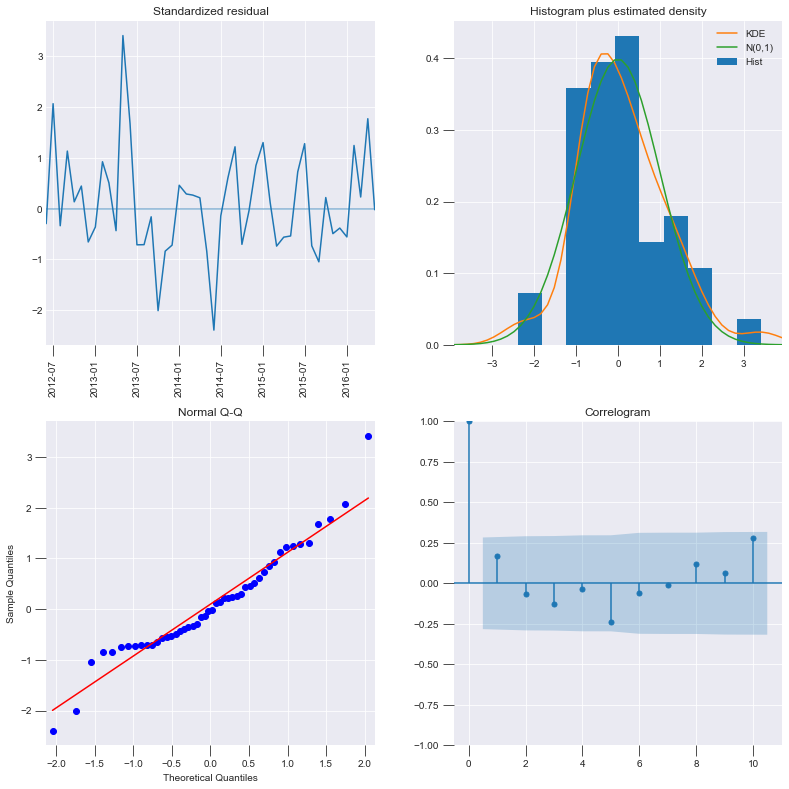

In [28]:
fit_arima_model(df_train, arima_param_b, zc_3)

#### One-Step Ahead Forecast (dynamic=False)

In [29]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_3, pred_start_date=pred_sd_b)
out_list_b.append(output_b)

The mean square error of our forcast is : 121075.57.
The root mean square error of our forcast is 347.96.


#### One-Step Ahead Forecast (Dynamic=True)

In [30]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_3,
                             pred_start_date=pred_sd_b, dynamic=True)
out_list_b.append(output_b)

The mean square error of our forcast is : 24744032.89.
The root mean square error of our forcast is 4974.34.


### Zip Code 27701 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [31]:
zc_4 = 75234

*** ARIMA Parameters, (0, 2, 2) ***
*** Coefficients Statistics, 75234 ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, 75234 ***


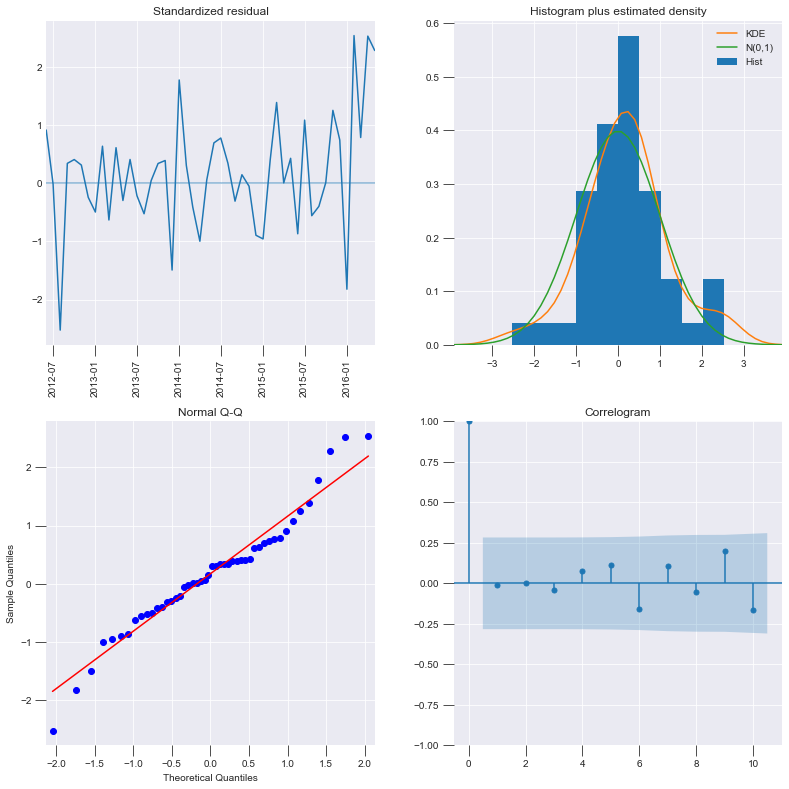

In [32]:
fit_arima_model(df_train, arima_param_b, zc_4)

#### One-Step Ahead Forecast (dynamic=False)

In [33]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_4, pred_start_date=pred_sd_b)
out_list_b.append(output_b)

The mean square error of our forcast is : 108518.44.
The root mean square error of our forcast is 329.42.


#### One-Step Ahead Forecast (dynamic=True)

In [34]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_4,
                             pred_start_date=pred_sd_b, dynamic=True)
out_list_b.append(output_b)

The mean square error of our forcast is : 34829554.05.
The root mean square error of our forcast is 5901.66.


### Zip Code 20722 ARIMA Results

In [35]:
zc_5 = 75233

#### Coefficient P-Values and Diagnostic Plots

*** ARIMA Parameters, (1, 2, 2) ***
*** Coefficients Statistics, 75233 ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, 75233 ***


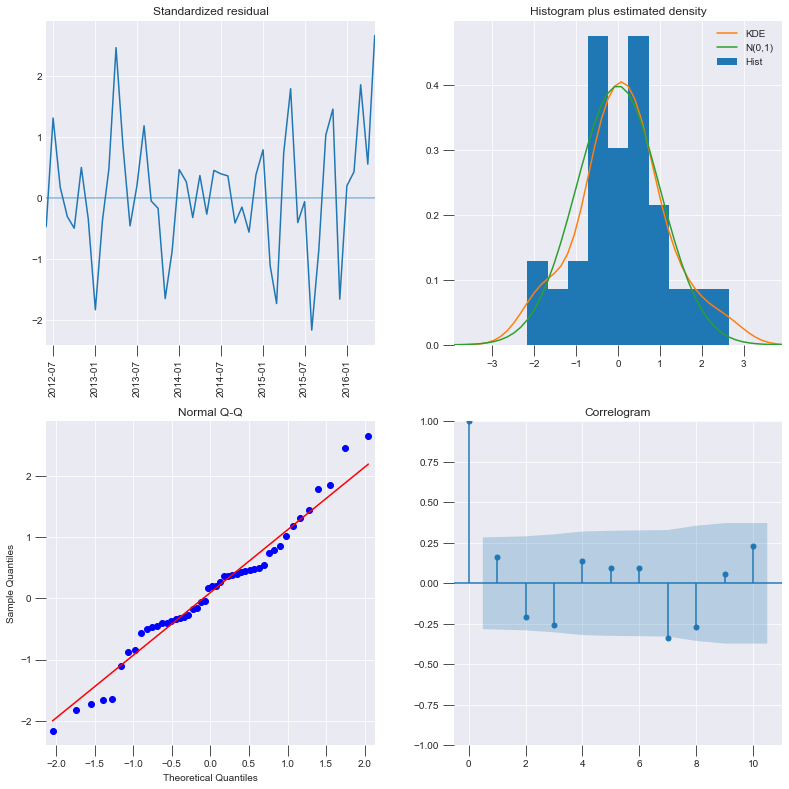

In [36]:
fit_arima_model(df_train, arima_param_b, zc_5)

#### One-Step Ahead Forecast (dynamic=False)

In [37]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_5, pred_start_date=pred_sd_b)
out_list_b.append(output_b)

The mean square error of our forcast is : 132103.7.
The root mean square error of our forcast is 363.46.


#### One-Step Ahead Forecast (dynamic=True)

In [38]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_5,
                             pred_start_date=pred_sd_b, dynamic=True)
out_list_b.append(output_b)

The mean square error of our forcast is : 1663997.16.
The root mean square error of our forcast is 1289.96.


### RMSE Results

In [39]:
df_mse_b = pd.DataFrame.from_dict(out_list_b)
df_mse_b.sort_values('dynamic')

zc  dynamic                                             output  \
0  28227    False  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
2  28262    False  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
4  28273    False  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
6  75234    False  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
8  75233    False  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
1  28227     True  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
3  28262     True  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
5  28273     True  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
7  75234     True  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
9  75233     True  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   

            mse      rmse  
0  7.312234e+04    270.41  
2  8.662350e+04    294.32  
4  1.210756e+05    347.96  
6  1.085184e+05    329.42  
8  1.321037e+05    363.46  
1  6.874028e+08  26218.37  
3  2.865623e+07   5353.15  
5  2.474403e+07   4974.34  
7  3.482955e+07   5901.66  
9  1.663997e+06   1289.96

In [40]:
plot_forecast_rmse(df_mse_b)

## Model Interpretatioin

### Compare Models' RMSEs

In [44]:
# comparing Model RMSE
filter_rmse = pd.DataFrame()
# for df , model in list(zip([df_mse_a, df_mse_b, df_mse_c], ['A', 'B', 'C'])):
for df , model in list(zip([df_mse_b], ['B'])):
    tmp = df[df['dynamic'] == True][['zc','rmse']]
    tmp['model'] = model
    filter_rmse = pd.concat([filter_rmse, tmp])
    
plot_forecast_rmse(filter_rmse, x='zc', color='model', dy_only=True)

#### Define Forecast Model Parameters

In [42]:
# define final parameters for arima and sarima
df_fc = df_ts[df_ts.time > '2011-12-01']
arima_fc_param = arima_param_b

# preview data
display(df_fc.head())
print('***  ARIMA Parameters ***')
display(arima_fc_param)

RegionID  RegionName            City State              Metro  \
4347     69789       28227       Mint Hill    NC          Charlotte   
4348     69813       28262       Charlotte    NC          Charlotte   
4349     69820       28273       Charlotte    NC          Charlotte   
4350     90786       75234  Farmers Branch    TX  Dallas-Fort Worth   
4351     90785       75233          Dallas    TX  Dallas-Fort Worth   

       CountyName  SizeRank        PTR       ROI       COC    RStdDev  \
4347  Mecklenburg       473  11.642424  0.220085  0.105303  70.566747   
4348  Mecklenburg       919  11.654545  0.182490  0.104810  70.566747   
4349  Mecklenburg      1815  12.060606  0.174360  0.097857  70.566747   
4350       Dallas      3158  13.166779  0.519160  0.084052  73.617040   
4351       Dallas      7886  11.484357  0.517799  0.112431  73.617040   

           time     value  
4347 2012-01-01  119800.0  
4348 2012-01-01  124600.0  
4349 2012-01-01  126000.0  
4350 2012-01-01  120400.0  
4351 2012-01-01   96100.0

***  ARIMA Parameters ***


zc        pdq         AIC
8    28227  (0, 2, 2)  680.897177
32   28262  (0, 2, 2)  682.592522
65   28273  (1, 2, 2)  705.460398
80   75234  (0, 2, 2)  699.466137
113  75233  (1, 2, 2)  706.103843

In [43]:
df_fc_results = pd.DataFrame()
for zc in arima_fc_param['zc']:
    tmp = get_a_s_fc(df_fc, zc, arima_fc_param, '2018-04-01', '2023-04-01')
    df_fc_results = df_fc_results.append(tmp)
    
df_fc_results    

zip_code  mean_roi  upper_roi  lower_roi  sale_price  purchase_price
0     28227      0.60       1.39      -0.19    350093.0        192100.0
0     28262      0.23       1.07      -0.61    269111.0        192300.0
0     28273      0.21       0.44      -0.01    274003.0        199000.0
0     75234     -0.11       1.87      -2.08    234295.0        234000.0
0     75233      1.23       3.18      -0.72    515661.0        204100.0